In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import glob
import os
import json
from datetime import datetime, timedelta
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import folium
from folium.plugins import HeatMap, MarkerCluster

warnings.filterwarnings('ignore')

# Advanced plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

print("EV PERFORMANCE ANALYSIS")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("Project: EV Industry Market Intelligence")
print("=" * 60)

EV PERFORMANCE ANALYSIS
Analysis Date: 2025-08-29 00:34
Project: EV Industry Market Intelligence


In [8]:
import os
import glob
import pandas as pd

# Navigate to project root if we're in notebooks directory
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

RAW_DATA_DIR = "data/raw"

def latest_file(pattern):
    """Return the most recent file matching a pattern"""
    files = glob.glob(os.path.join(RAW_DATA_DIR, pattern))
    if not files:
        raise FileNotFoundError(f"No files found for pattern: {pattern}")
    return max(files, key=os.path.getctime)

try:
    # Load latest datasets
    epa_file = latest_file("epa_vehicles_20250829.csv")
    stations_file = latest_file("charging_stations_*_20250829.csv")  # Wildcard for CA or other states
    sales_file = latest_file("ev_sales_data_20250829.csv")
    
    df_vehicles = pd.read_csv(epa_file)
    df_stations = pd.read_csv(stations_file)
    
    # Try to parse dates in sales file, handle if column doesn't exist
    try:
        df_sales = pd.read_csv(sales_file, parse_dates=["date"])
    except (KeyError, ValueError):
        df_sales = pd.read_csv(sales_file)
        print("Note: Could not parse 'date' column in sales data")
    
    print("Loaded datasets:")
    print(f"- Vehicles: {epa_file} ({df_vehicles.shape})")
    print(f"- Stations: {stations_file} ({df_stations.shape})")
    print(f"- Sales: {sales_file} ({df_sales.shape})")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Available files in data/raw:")
    all_files = glob.glob(os.path.join(RAW_DATA_DIR, "*.csv"))
    for file in all_files:
        print(f"  - {os.path.basename(file)}")
        
except Exception as e:
    print(f"Error loading datasets: {e}")

Loaded datasets:
- Vehicles: data/raw/epa_vehicles_20250829.csv ((48, 17))
- Stations: data/raw/charging_stations_CA_20250829.csv ((19915, 30))
- Sales: data/raw/ev_sales_data_20250829.csv ((80, 12))


In [10]:
# Figure saving setup
import os
from datetime import datetime

# Create directory
os.makedirs('outputs/figures', exist_ok=True)

# Helper function for saving figures
def save_current_figure(plot_name):
    """Save the current matplotlib figure with timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d")
    filename = f'outputs/figures/{plot_name}_{timestamp}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {filename}")

In [12]:
def load_ev_datasets():
    """Enhanced data loading with comprehensive validation"""
    
    # Navigate to project root
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')
    
    print(f"Working Directory: {os.getcwd()}")
    
    # Find latest data files
    file_patterns = {
        'vehicles': 'data/raw/epa_vehicles_*.csv',
        'stations': 'data/raw/charging_stations_*.csv',
        'sales': 'data/raw/ev_sales_data_*.csv'
    }
    
    datasets = {}
    file_info = {}
    
    for name, pattern in file_patterns.items():
        files = sorted(glob.glob(pattern))
        if not files:
            print(f"No {name} files found matching {pattern}")
            continue
            
        latest_file = files[-1]
        file_info[name] = latest_file
        
        try:
            df = pd.read_csv(latest_file)
            if df.empty:
                print(f"{name}: Empty dataset")
                continue
            
            datasets[name] = df
            print(f"{name}: {len(df):,} rows × {len(df.columns)} columns")
            
        except Exception as e:
            print(f"{name}: Loading error - {e}")
    
    return datasets, file_info

# Load datasets
datasets, file_info = load_ev_datasets()
required_datasets = ['vehicles', 'stations', 'sales']

if not all(dataset in datasets for dataset in required_datasets):
    print("\nCritical datasets missing. Please run data collection script first.")
    print("Run: python src/data_collection.py")
else:
    vehicles_df = datasets['vehicles'].copy()
    stations_df = datasets['stations'].copy()
    sales_df = datasets['sales'].copy()
    print(f"\nAll datasets loaded successfully!")


Working Directory: /Users/evanfu/Documents/Personal Projects/EV Performance Analysis/ev-performance-analysis
vehicles: 48 rows × 17 columns
stations: 19,915 rows × 30 columns
sales: 80 rows × 12 columns

All datasets loaded successfully!



EV EFFICIENCY ANALYSIS
Saved: outputs/figures/ev_efficiency_20250829.png


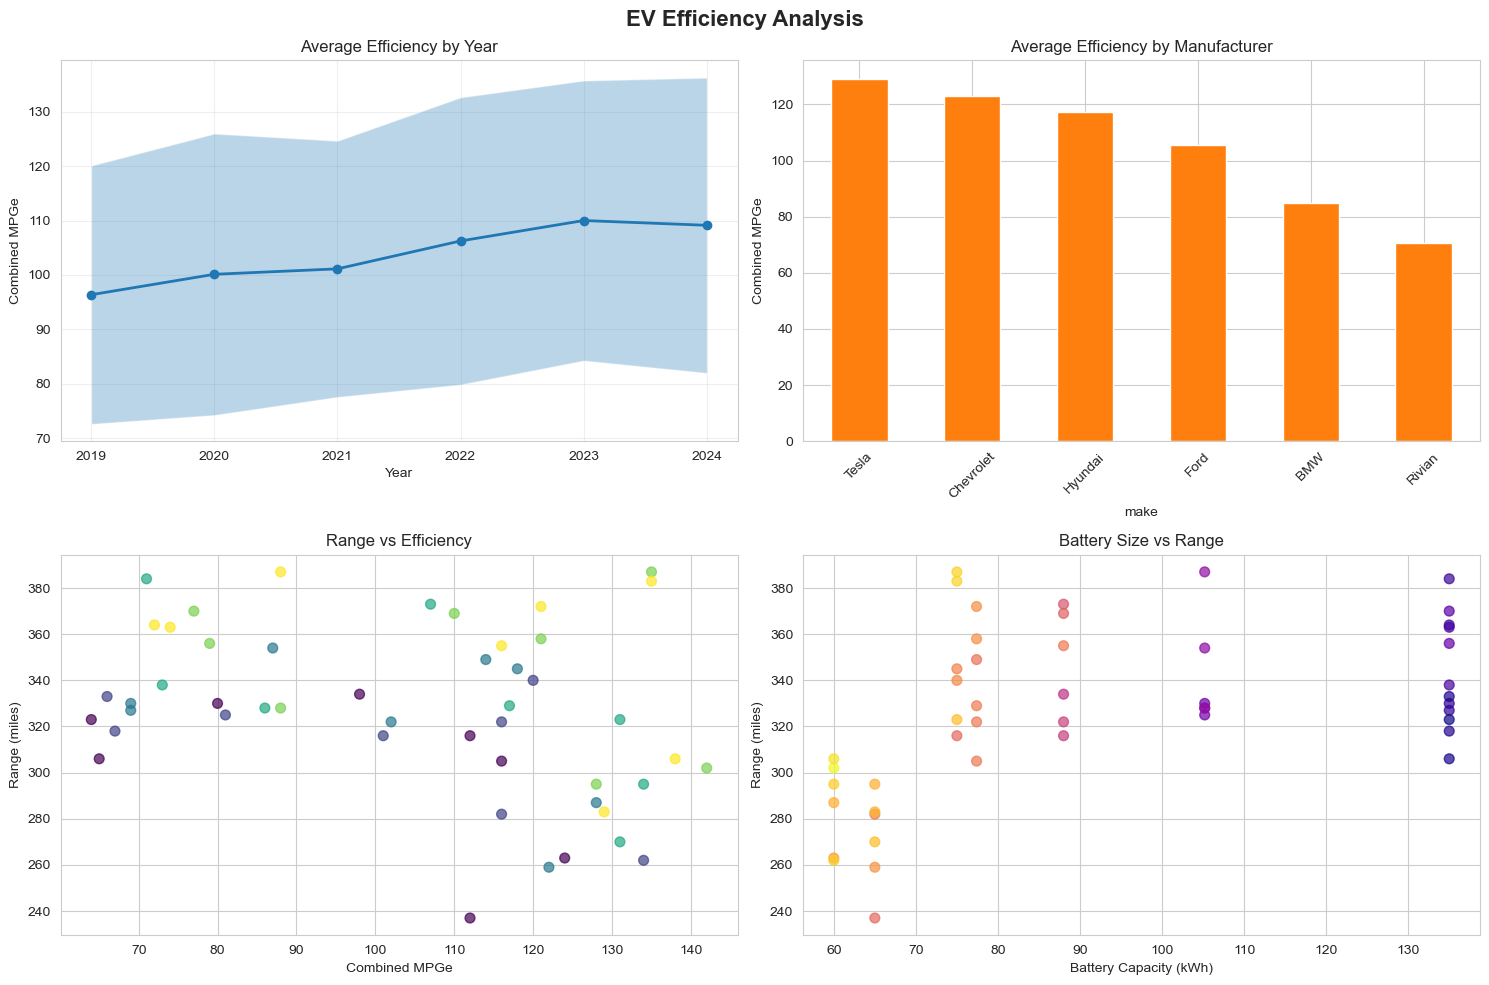


STATISTICAL INSIGHTS:
Average efficiency improvement per year: 2.1 MPGe
Saved: outputs/figures/ev_performance_correlation_20250829.png


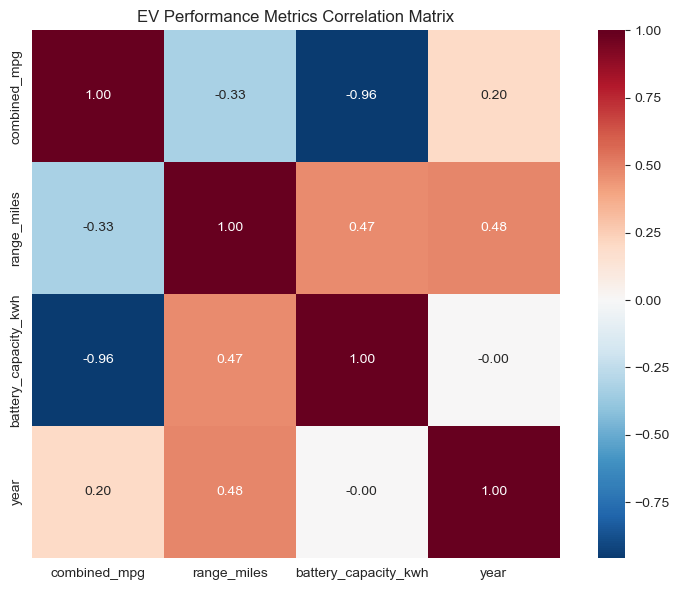


Strongest positive correlation: 1.00
Strongest negative correlation: -0.96


In [14]:
def analyze_ev_efficiency():
    """Advanced analysis of EV efficiency trends and patterns"""
    
    print("\nEV EFFICIENCY ANALYSIS")
    print("=" * 50)
    
    # 1. Efficiency trends over time
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('EV Efficiency Analysis', fontsize=16, fontweight='bold')
    
    # Efficiency by year
    yearly_efficiency = vehicles_df.groupby('year')['combined_mpg'].agg(['mean', 'std'])
    axes[0,0].plot(yearly_efficiency.index, yearly_efficiency['mean'], marker='o', linewidth=2)
    axes[0,0].fill_between(yearly_efficiency.index, 
                          yearly_efficiency['mean'] - yearly_efficiency['std'],
                          yearly_efficiency['mean'] + yearly_efficiency['std'], 
                          alpha=0.3)
    axes[0,0].set_title('Average Efficiency by Year')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Combined MPGe')
    axes[0,0].grid(True, alpha=0.3)
    
    # Efficiency by manufacturer
    make_efficiency = vehicles_df.groupby('make')['combined_mpg'].mean().sort_values(ascending=False)
    make_efficiency.plot(kind='bar', ax=axes[0,1], color=color_palette[1])
    axes[0,1].set_title('Average Efficiency by Manufacturer')
    axes[0,1].set_ylabel('Combined MPGe')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Range vs Efficiency scatter
    axes[1,0].scatter(vehicles_df['combined_mpg'], vehicles_df['range_miles'], 
                     c=vehicles_df['year'], cmap='viridis', alpha=0.7, s=50)
    axes[1,0].set_xlabel('Combined MPGe')
    axes[1,0].set_ylabel('Range (miles)')
    axes[1,0].set_title('Range vs Efficiency')
    
    # Battery capacity vs Range
    if 'battery_capacity_kwh' in vehicles_df.columns:
        axes[1,1].scatter(vehicles_df['battery_capacity_kwh'], vehicles_df['range_miles'],
                         c=vehicles_df['combined_mpg'], cmap='plasma', alpha=0.7, s=50)
        axes[1,1].set_xlabel('Battery Capacity (kWh)')
        axes[1,1].set_ylabel('Range (miles)')
        axes[1,1].set_title('Battery Size vs Range')
    
    plt.tight_layout()
    save_current_figure("ev_efficiency")
    plt.show()
    
    # Statistical analysis
    print("\nSTATISTICAL INSIGHTS:")
    print(f"Average efficiency improvement per year: {(yearly_efficiency['mean'].iloc[-1] - yearly_efficiency['mean'].iloc[0]) / len(yearly_efficiency):.1f} MPGe")
    
    # Correlation analysis
    numeric_cols = ['combined_mpg', 'range_miles', 'battery_capacity_kwh', 'year']
    available_cols = [col for col in numeric_cols if col in vehicles_df.columns]
    
    if len(available_cols) > 2:
        corr_matrix = vehicles_df[available_cols].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, fmt='.2f')
        plt.title('EV Performance Metrics Correlation Matrix')
        plt.tight_layout()
        save_current_figure("ev_performance_correlation")
        plt.show()
        
        print(f"\nStrongest positive correlation: {corr_matrix.unstack().sort_values(ascending=False).iloc[1]:.2f}")
        print(f"Strongest negative correlation: {corr_matrix.unstack().sort_values().iloc[0]:.2f}")

if 'vehicles_df' in globals():
    analyze_ev_efficiency()


CHARGING INFRASTRUCTURE ANALYSIS
Saved: outputs/figures/ev_charging_infrastructure_20250828.png


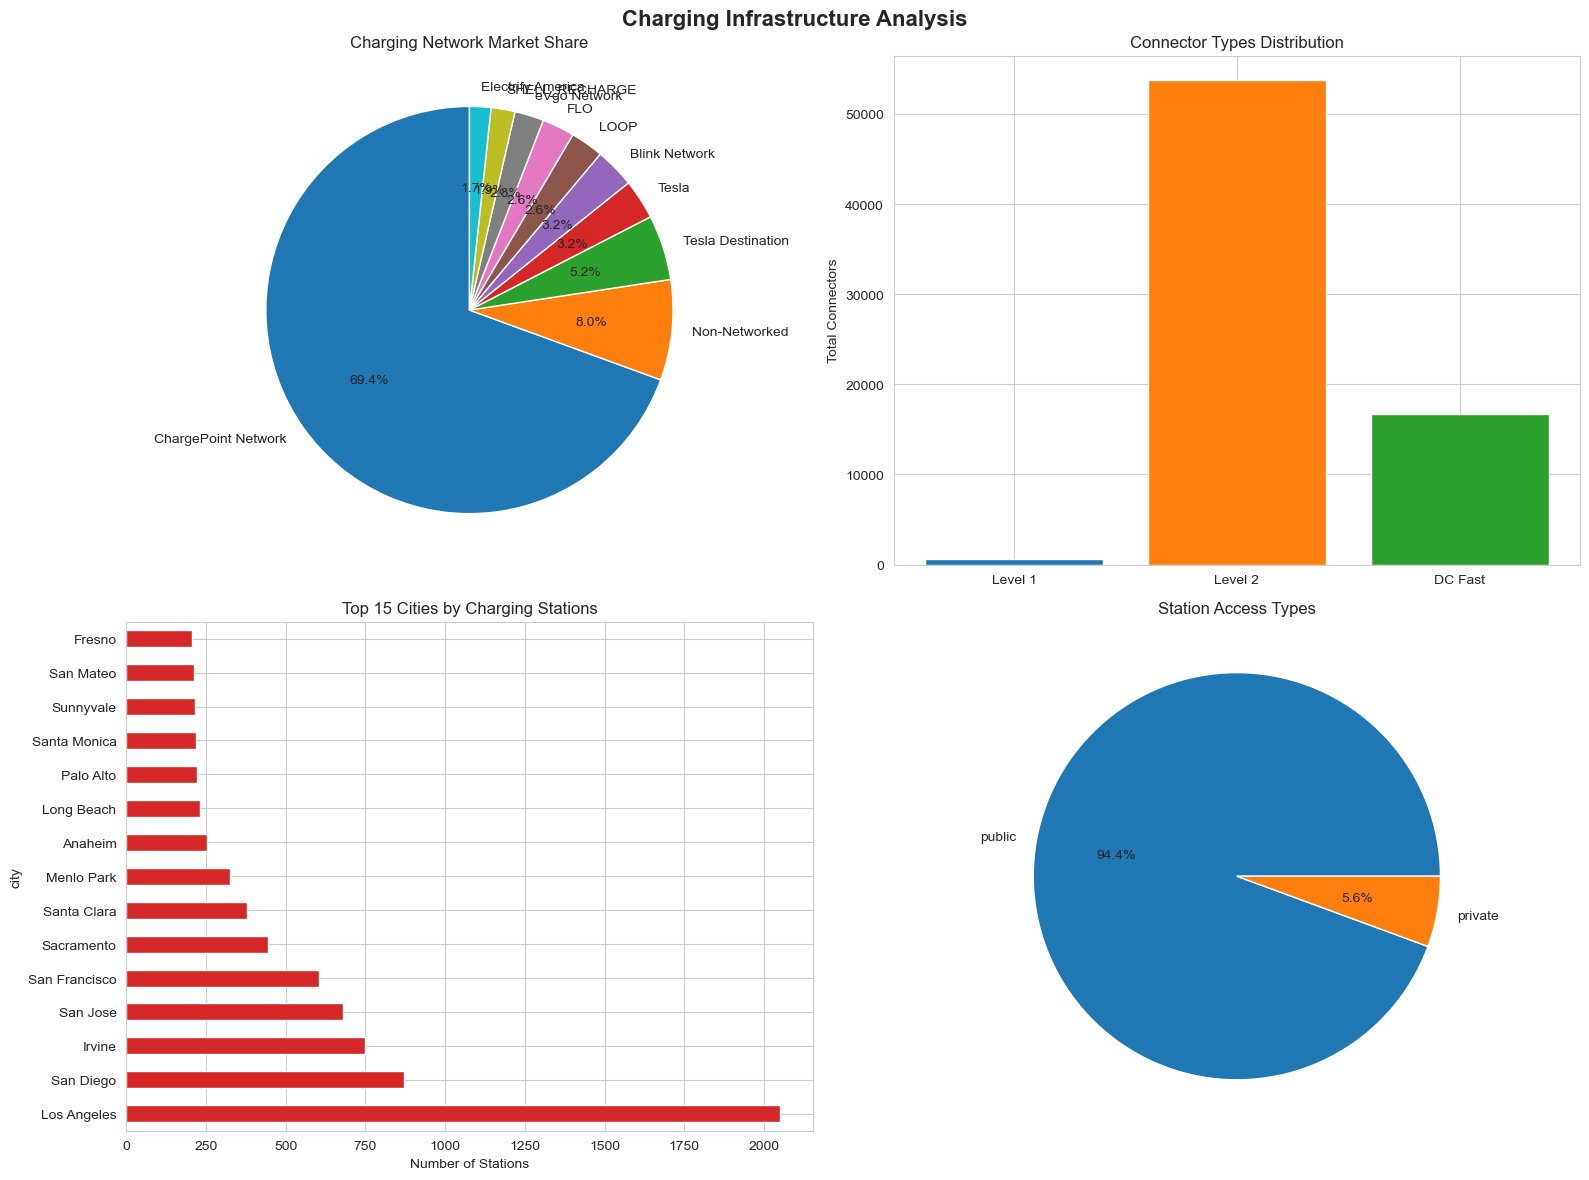


INFRASTRUCTURE INSIGHTS:
Total charging stations analyzed: 19,923
Total charging connectors: 71,144
Average connectors per station: 3.6
Stations with DC Fast charging: 2,666 (13.4%)
Market concentration (top network): 64.3%

Geographic coverage:
Latitude range: 32.54 to 41.96
Longitude range: -124.27 to -114.56


In [38]:
def analyze_charging_infrastructure():
    """Comprehensive charging infrastructure analysis"""
    
    print("\nCHARGING INFRASTRUCTURE ANALYSIS")
    print("=" * 50)
    
    # 1. Network distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Charging Infrastructure Analysis', fontsize=16, fontweight='bold')
    
    # Network market share
    network_counts = stations_df['network'].value_counts().head(10)
    network_counts.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Charging Network Market Share')
    axes[0,0].set_ylabel('')
    
    # Connector types distribution
    stations_df['total_connectors'] = (stations_df['level1_count'] + 
                                     stations_df['level2_count'] + 
                                     stations_df['dc_fast_count'])
    
    connector_data = {
        'Level 1': stations_df['level1_count'].sum(),
        'Level 2': stations_df['level2_count'].sum(), 
        'DC Fast': stations_df['dc_fast_count'].sum()
    }
    
    axes[0,1].bar(connector_data.keys(), connector_data.values(), color=color_palette[:3])
    axes[0,1].set_title('Connector Types Distribution')
    axes[0,1].set_ylabel('Total Connectors')
    
    # Geographic distribution by city
    city_counts = stations_df['city'].value_counts().head(15)
    city_counts.plot(kind='barh', ax=axes[1,0], color=color_palette[3])
    axes[1,0].set_title('Top 15 Cities by Charging Stations')
    axes[1,0].set_xlabel('Number of Stations')
    
    # Access type distribution
    if 'access_code' in stations_df.columns:
        access_counts = stations_df['access_code'].value_counts()
        axes[1,1].pie(access_counts.values, labels=access_counts.index, autopct='%1.1f%%')
        axes[1,1].set_title('Station Access Types')
    
    plt.tight_layout()
    save_current_figure("ev_charging_infrastructure")
    plt.show()
    
    # Advanced analysis
    print("\nINFRASTRUCTURE INSIGHTS:")
    total_stations = len(stations_df)
    total_connectors = stations_df['total_connectors'].sum()
    
    print(f"Total charging stations analyzed: {total_stations:,}")
    print(f"Total charging connectors: {total_connectors:,}")
    print(f"Average connectors per station: {total_connectors/total_stations:.1f}")
    
    # DC Fast charging analysis
    dc_fast_stations = stations_df[stations_df['dc_fast_count'] > 0]
    print(f"Stations with DC Fast charging: {len(dc_fast_stations):,} ({len(dc_fast_stations)/total_stations*100:.1f}%)")
    
    # Network concentration analysis
    network_concentration = stations_df['network'].value_counts().iloc[0] / total_stations
    print(f"Market concentration (top network): {network_concentration*100:.1f}%")
    
    # Geographic analysis
    if 'latitude' in stations_df.columns and 'longitude' in stations_df.columns:
        print(f"\nGeographic coverage:")
        print(f"Latitude range: {stations_df['latitude'].min():.2f} to {stations_df['latitude'].max():.2f}")
        print(f"Longitude range: {stations_df['longitude'].min():.2f} to {stations_df['longitude'].max():.2f}")

if 'stations_df' in globals():
    analyze_charging_infrastructure()


EV MARKET GROWTH ANALYSIS
Saved: outputs/figures/ev_market_growth_20250829.png


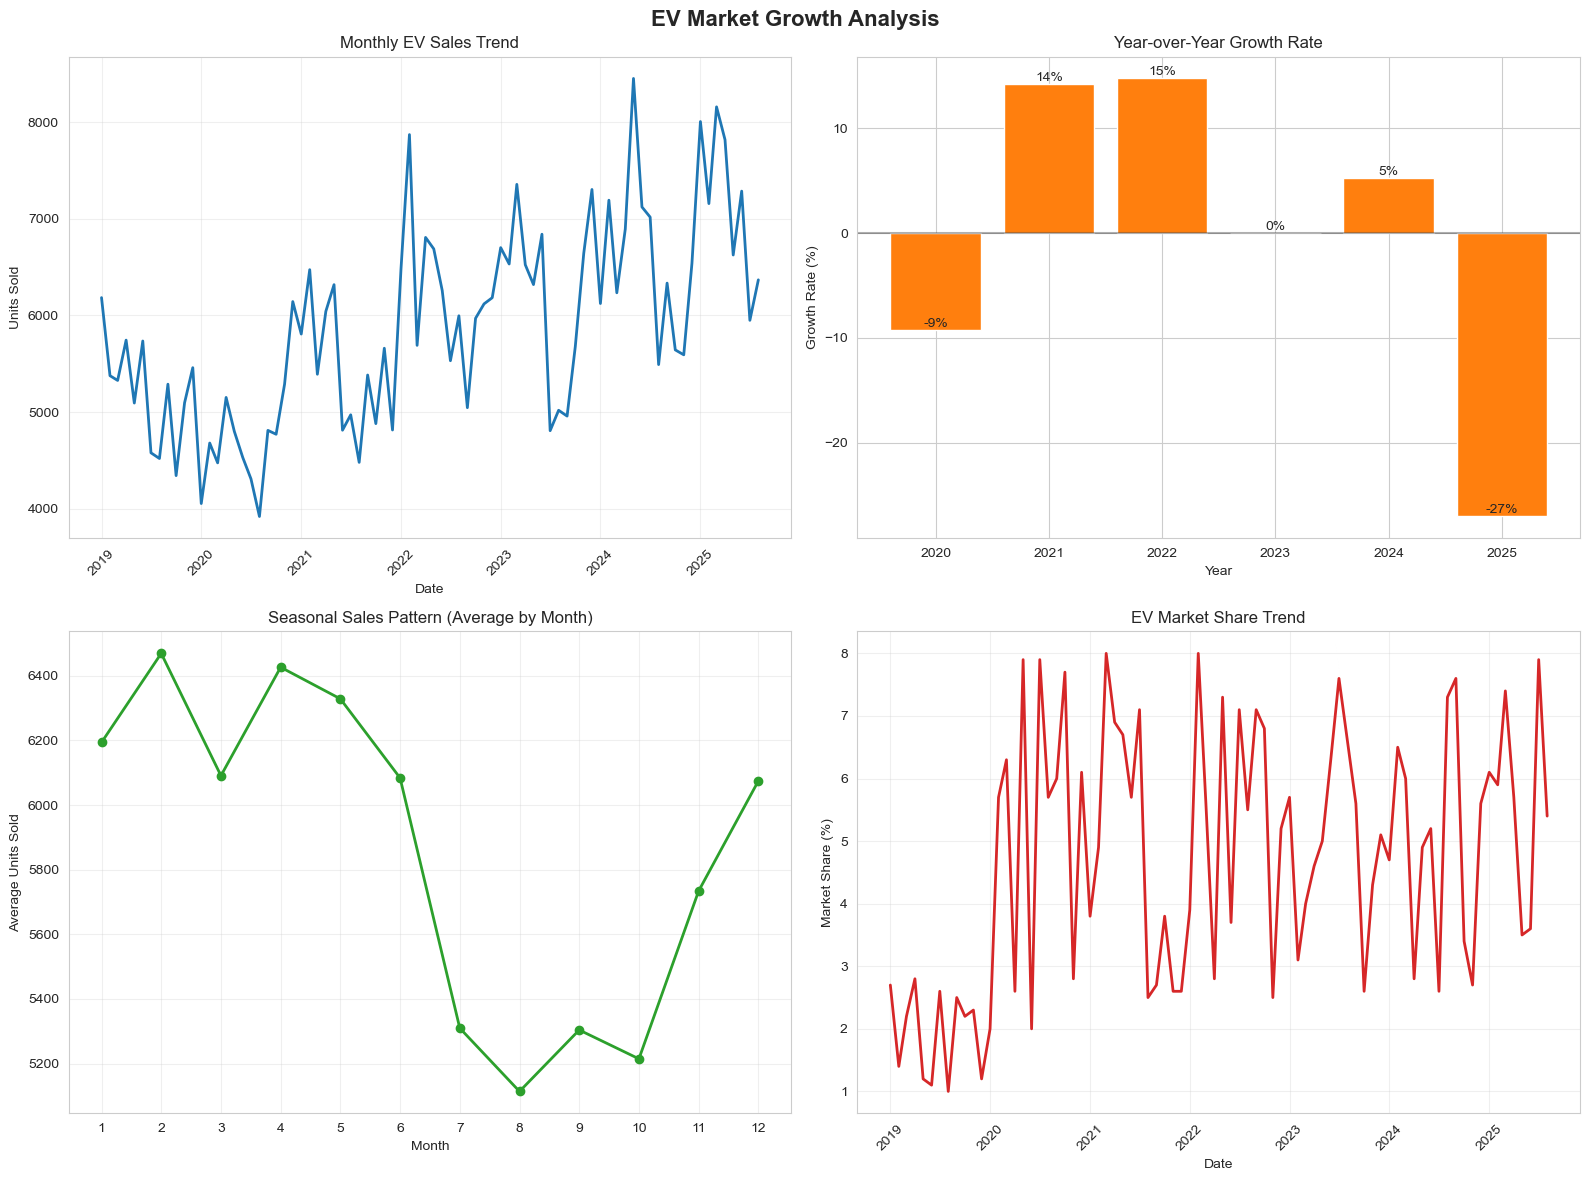


MARKET INSIGHTS:
Total EV sales (dataset period): 470,089 units
Compound Annual Growth Rate (CAGR): -1.5%
Most recent year-over-year growth: -27.0%
Peak sales month: 2 | Lowest: 8
Seasonal variation: 23.1%
Market share growth: 2.7% → 5.4% (+2.7pp)


In [16]:
def analyze_market_growth(sales_df, color_palette=None):
    """Comprehensive EV market growth and trends analysis"""
    
    if color_palette is None:
        color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # default colors
    
    print("\nEV MARKET GROWTH ANALYSIS")
    print("=" * 50)
    
    # Prepare time series data
    sales_df = sales_df.copy()
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df = sales_df.sort_values('date')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('EV Market Growth Analysis', fontsize=16, fontweight='bold')
    
    # 1. Monthly sales trend
    axes[0,0].plot(sales_df['date'], sales_df['total_ev_sales'], linewidth=2, color=color_palette[0])
    axes[0,0].set_title('Monthly EV Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Units Sold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Year-over-year growth
    yearly_sales = sales_df.groupby('year')['total_ev_sales'].sum()
    yoy_growth = yearly_sales.pct_change() * 100
    
    bars = axes[0,1].bar(yoy_growth.index[1:], yoy_growth.values[1:], color=color_palette[1])
    axes[0,1].set_title('Year-over-Year Growth Rate')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.0f}%', ha='center', va='bottom')
    
    # 3. Seasonal analysis
    monthly_avg = sales_df.groupby('month')['total_ev_sales'].mean()
    axes[1,0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, color=color_palette[2])
    axes[1,0].set_title('Seasonal Sales Pattern (Average by Month)')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Average Units Sold')
    axes[1,0].set_xticks(range(1, 13))
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Market share trend
    if 'market_share_percent' in sales_df.columns:
        axes[1,1].plot(sales_df['date'], sales_df['market_share_percent'], 
                       linewidth=2, color=color_palette[3])
        axes[1,1].set_title('EV Market Share Trend')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Market Share (%)')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    save_current_figure("ev_market_growth")
    plt.show()
    
    # Growth metrics
    print("\nMARKET INSIGHTS:")
    total_sales = sales_df['total_ev_sales'].sum()
    print(f"Total EV sales (dataset period): {total_sales:,} units")
    
    # Calculate CAGR (Compound Annual Growth Rate)
    first_year_sales = yearly_sales.iloc[0]
    last_year_sales = yearly_sales.iloc[-1]
    years = len(yearly_sales) - 1
    if years > 0 and first_year_sales > 0:
        cagr = (last_year_sales / first_year_sales) ** (1/years) - 1
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.1f}%")
    
    # Recent growth
    if len(yoy_growth) > 1:
        recent_growth = yoy_growth.iloc[-1]
        print(f"Most recent year-over-year growth: {recent_growth:.1f}%")
    
    # Seasonal insights
    peak_month = monthly_avg.idxmax()
    low_month = monthly_avg.idxmin()
    seasonality = (monthly_avg.max() - monthly_avg.min()) / monthly_avg.mean() * 100
    print(f"Peak sales month: {peak_month} | Lowest: {low_month}")
    print(f"Seasonal variation: {seasonality:.1f}%")
    
    # Market share analysis
    if 'market_share_percent' in sales_df.columns:
        current_share = sales_df['market_share_percent'].iloc[-1]
        first_share = sales_df['market_share_percent'].iloc[0]
        share_growth = current_share - first_share
        print(f"Market share growth: {first_share:.1f}% → {current_share:.1f}% (+{share_growth:.1f}pp)")

# Call it like this
if 'sales_df' in globals():
    analyze_market_growth(sales_df, color_palette)



COMPETITIVE ANALYSIS
Saved: outputs/figures/ev_manufacturer_competition_20250829.png


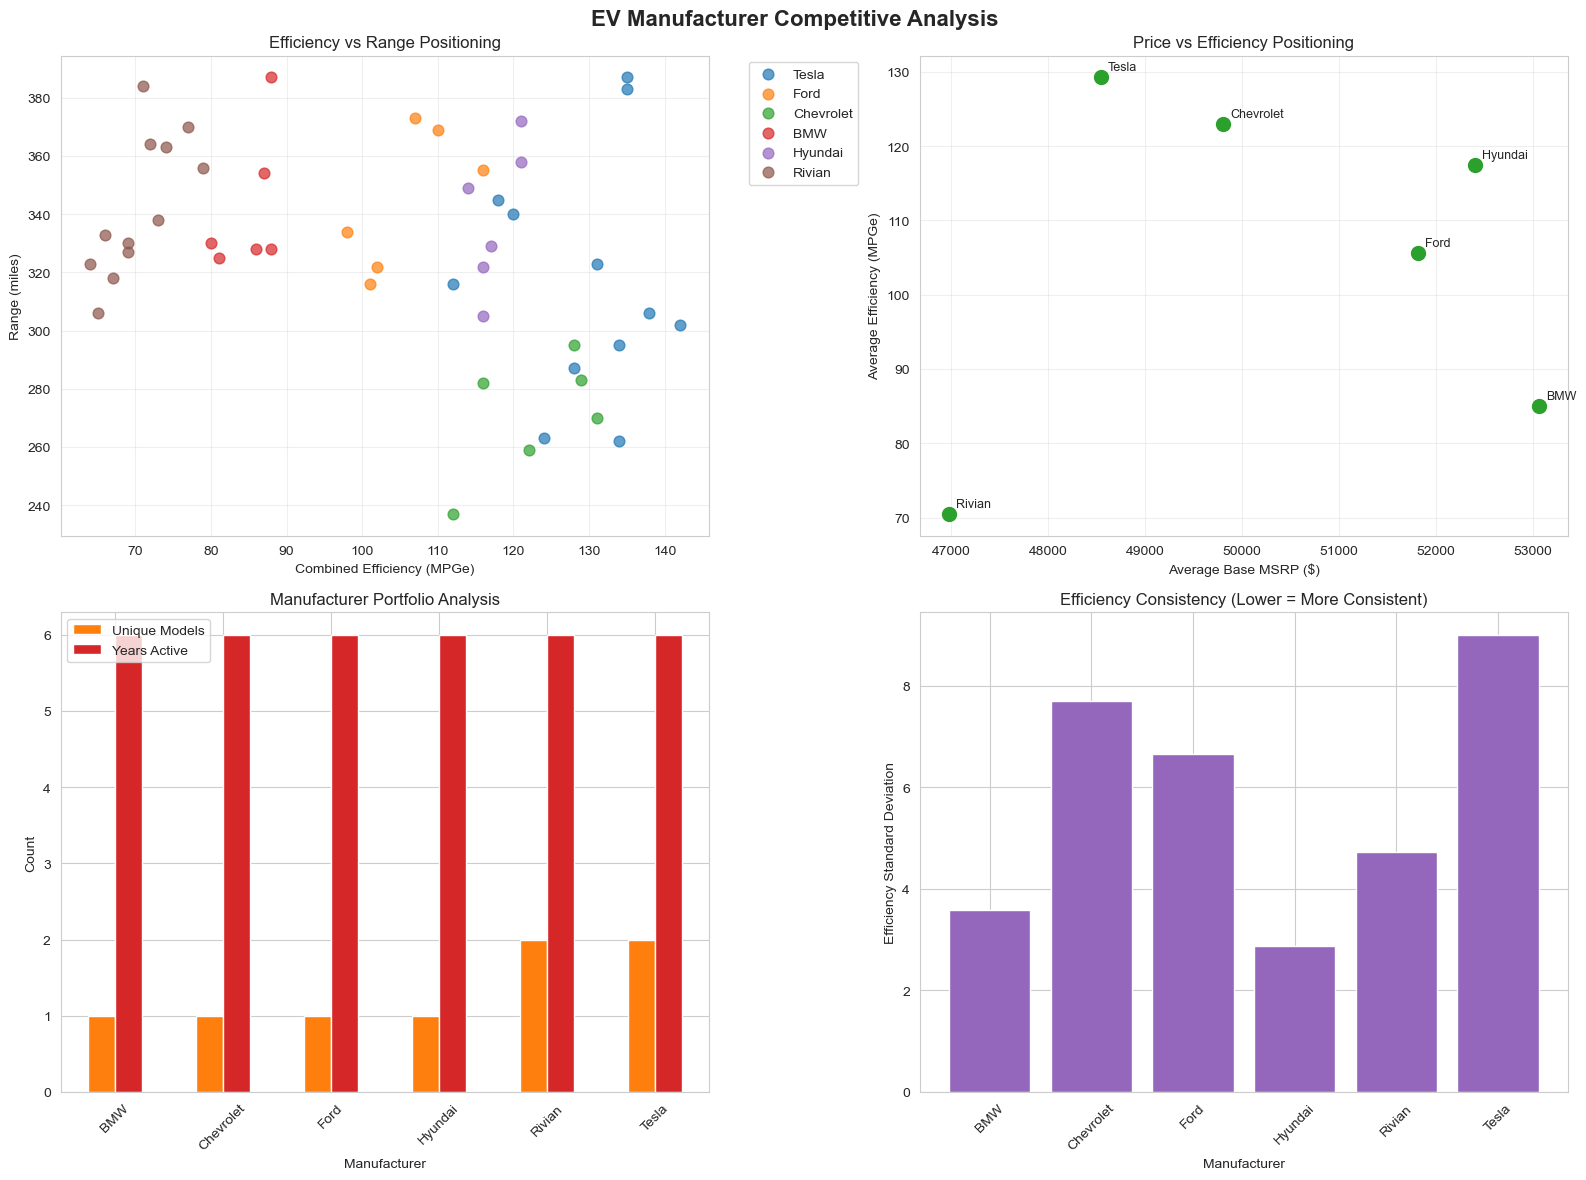


COMPETITIVE INSIGHTS:
Efficiency leader: Tesla
Range leader: Ford
Value leader (efficiency/price): Tesla

POSITIONING MATRIX:
Tesla: Mass Market | High Efficiency | Avg Range: 317mi
Ford: Premium | Standard Efficiency | Avg Range: 345mi
Chevrolet: Premium | High Efficiency | Avg Range: 271mi
BMW: Premium | Standard Efficiency | Avg Range: 342mi
Hyundai: Premium | High Efficiency | Avg Range: 339mi
Rivian: Mass Market | Standard Efficiency | Avg Range: 343mi


In [18]:
def competitive_analysis():
    """Advanced competitive analysis of EV manufacturers"""
    
    print("\nCOMPETITIVE ANALYSIS")
    print("=" * 50)
    
    # Create comprehensive manufacturer analysis
    manufacturer_metrics = vehicles_df.groupby('make').agg({
        'combined_mpg': ['mean', 'std'],
        'range_miles': ['mean', 'max'], 
        'year': 'count',
        'msrp_base': ['mean', 'min', 'max']
    }).round(2)
    
    # Flatten column names
    manufacturer_metrics.columns = ['_'.join(col).strip() for col in manufacturer_metrics.columns]
    manufacturer_metrics = manufacturer_metrics.reset_index()
    
    # Create competitive positioning chart
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('EV Manufacturer Competitive Analysis', fontsize=16, fontweight='bold')
    
    # 1. Efficiency vs Range positioning
    for i, make in enumerate(vehicles_df['make'].unique()):
        make_data = vehicles_df[vehicles_df['make'] == make]
        axes[0,0].scatter(make_data['combined_mpg'], make_data['range_miles'], 
                         label=make, alpha=0.7, s=60, color=color_palette[i % len(color_palette)])
    
    axes[0,0].set_xlabel('Combined Efficiency (MPGe)')
    axes[0,0].set_ylabel('Range (miles)')
    axes[0,0].set_title('Efficiency vs Range Positioning')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Price positioning
    price_efficiency = vehicles_df.groupby('make')[['msrp_base', 'combined_mpg']].mean()
    price_efficiency.plot.scatter(x='msrp_base', y='combined_mpg', 
                                 s=100, ax=axes[0,1], color=color_palette[2])
    
    # Add manufacturer labels
    for idx, row in price_efficiency.iterrows():
        axes[0,1].annotate(idx, (row['msrp_base'], row['combined_mpg']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[0,1].set_xlabel('Average Base MSRP ($)')
    axes[0,1].set_ylabel('Average Efficiency (MPGe)')
    axes[0,1].set_title('Price vs Efficiency Positioning')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Model portfolio breadth
    portfolio_breadth = vehicles_df.groupby('make').agg({
        'model': 'nunique',
        'year': lambda x: x.max() - x.min() + 1
    })
    portfolio_breadth.columns = ['Models', 'Years_Active']
    
    portfolio_breadth.plot.bar(ax=axes[1,0], color=[color_palette[1], color_palette[3]])
    axes[1,0].set_title('Manufacturer Portfolio Analysis')
    axes[1,0].set_xlabel('Manufacturer')
    axes[1,0].set_ylabel('Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend(['Unique Models', 'Years Active'])
    
    # 4. Performance consistency (efficiency std dev)
    consistency_data = vehicles_df.groupby('make')['combined_mpg'].agg(['mean', 'std'])
    bars = axes[1,1].bar(consistency_data.index, consistency_data['std'], color=color_palette[4])
    axes[1,1].set_title('Efficiency Consistency (Lower = More Consistent)')
    axes[1,1].set_xlabel('Manufacturer')
    axes[1,1].set_ylabel('Efficiency Standard Deviation')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    save_current_figure("ev_manufacturer_competition")
    plt.show()
    
    # Competitive insights
    print("\nCOMPETITIVE INSIGHTS:")
    
    # Market leaders
    efficiency_leader = vehicles_df.groupby('make')['combined_mpg'].mean().idxmax()
    range_leader = vehicles_df.groupby('make')['range_miles'].mean().idxmax()
    value_leader = vehicles_df.assign(value_score=vehicles_df['combined_mpg']/vehicles_df['msrp_base']*100000).groupby('make')['value_score'].mean().idxmax()
    
    print(f"Efficiency leader: {efficiency_leader}")
    print(f"Range leader: {range_leader}")
    print(f"Value leader (efficiency/price): {value_leader}")
    
    # Market positioning analysis
    print(f"\nPOSITIONING MATRIX:")
    for make in vehicles_df['make'].unique():
        make_data = vehicles_df[vehicles_df['make'] == make]
        avg_price = make_data['msrp_base'].mean()
        avg_efficiency = make_data['combined_mpg'].mean()
        avg_range = make_data['range_miles'].mean()
        
        # Determine market segment
        if avg_price > vehicles_df['msrp_base'].median():
            price_segment = "Premium"
        else:
            price_segment = "Mass Market"
            
        if avg_efficiency > vehicles_df['combined_mpg'].median():
            efficiency_segment = "High Efficiency"
        else:
            efficiency_segment = "Standard Efficiency"
        
        print(f"{make}: {price_segment} | {efficiency_segment} | Avg Range: {avg_range:.0f}mi")

if 'vehicles_df' in globals():
    competitive_analysis()


PREDICTIVE ANALYSIS & FORECASTING
Saved: outputs/figures/ev_trend_prediction_20250829.png


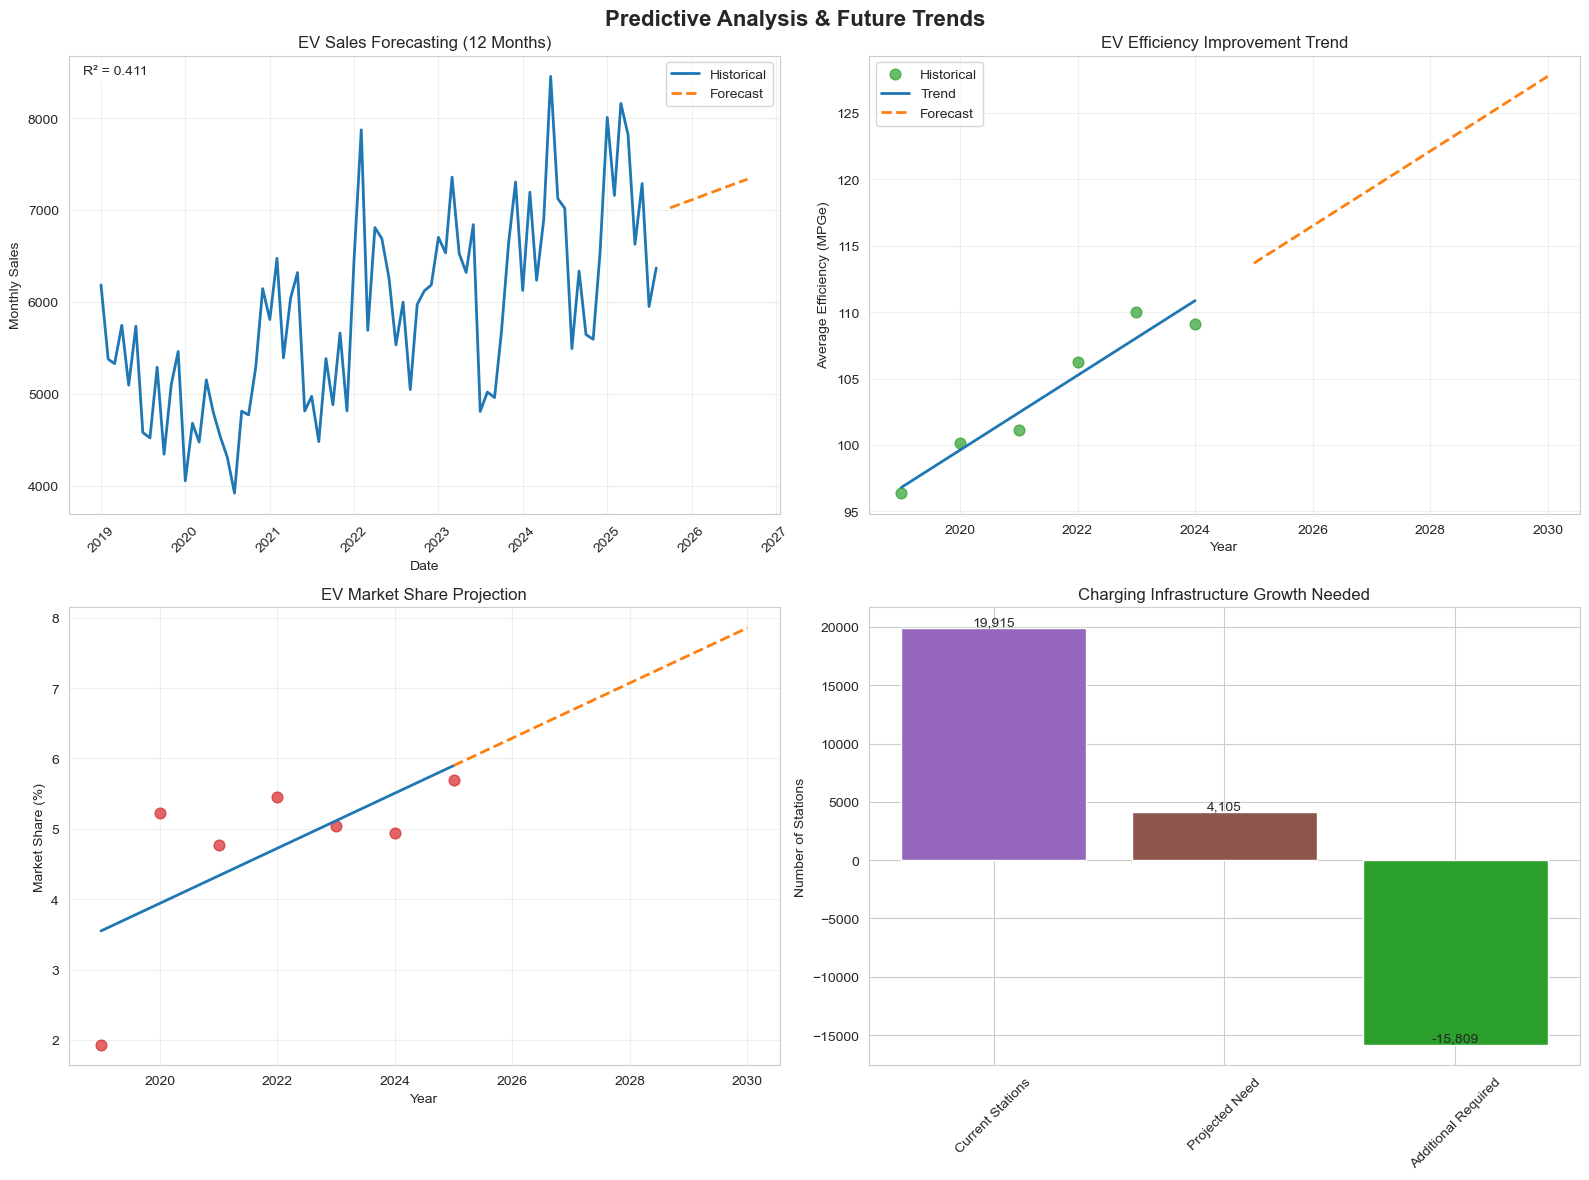


PREDICTIVE INSIGHTS:
Next 12 months projected sales: 86,148 units
Average monthly growth rate: 28 units/month
Projected 2030 efficiency: 128 MPGe
Projected 2030 market share: 7.9%

INFRASTRUCTURE INSIGHTS:
Current stations per 1,000 EVs: 53.0
Additional stations needed (next 12 months): -15,809
Required infrastructure growth rate: -79.4%


In [20]:
def predictive_analysis():
    """Predictive modeling for EV trends and forecasting"""
    
    print("\nPREDICTIVE ANALYSIS & FORECASTING")
    print("=" * 50)
    
    # --- Ensure 'date' is datetime ---
    sales_df_sorted = sales_df.copy()
    sales_df_sorted['date'] = pd.to_datetime(sales_df_sorted['date'])
    sales_df_sorted = sales_df_sorted.sort_values('date')
    sales_df_sorted['month_number'] = range(len(sales_df_sorted))
    
    # 1. Sales forecasting using linear regression
    X = sales_df_sorted['month_number'].values.reshape(-1, 1)
    y = sales_df_sorted['total_ev_sales'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Generate predictions for next 12 months
    last_month = sales_df_sorted['month_number'].max()
    future_months = np.arange(last_month + 1, last_month + 13).reshape(-1, 1)
    future_predictions = model.predict(future_months)
    
    # Create future dates (next 12 months after last date)
    last_date = sales_df_sorted['date'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                 periods=12, freq='M')
    
    # --- Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Predictive Analysis & Future Trends', fontsize=16, fontweight='bold')
    
    # Sales forecasting
    axes[0,0].plot(sales_df_sorted['date'], sales_df_sorted['total_ev_sales'], 
                   label='Historical', linewidth=2, color=color_palette[0])
    axes[0,0].plot(future_dates, future_predictions, 
                   label='Forecast', linewidth=2, linestyle='--', color=color_palette[1])
    axes[0,0].set_title('EV Sales Forecasting (12 Months)')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Monthly Sales')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Model performance
    train_predictions = model.predict(X)
    r2 = r2_score(y, train_predictions)
    axes[0,0].text(0.02, 0.98, f'R² = {r2:.3f}', transform=axes[0,0].transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # --- 2. Efficiency improvement trend ---
    yearly_efficiency = vehicles_df.groupby('year')['combined_mpg'].mean()
    
    X_eff = yearly_efficiency.index.values.reshape(-1, 1)
    y_eff = yearly_efficiency.values
    eff_model = LinearRegression().fit(X_eff, y_eff)
    
    future_years = np.arange(2025, 2031).reshape(-1, 1)
    future_efficiency = eff_model.predict(future_years)
    
    axes[0,1].scatter(yearly_efficiency.index, yearly_efficiency.values, 
                      s=60, color=color_palette[2], label='Historical', alpha=0.7)
    axes[0,1].plot(yearly_efficiency.index, eff_model.predict(X_eff), 
                   color=color_palette[0], linewidth=2, label='Trend')
    axes[0,1].plot(future_years.flatten(), future_efficiency, 
                   linestyle='--', color=color_palette[1], linewidth=2, label='Forecast')
    axes[0,1].set_title('EV Efficiency Improvement Trend')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Average Efficiency (MPGe)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # --- 3. Market share projection ---
    if 'market_share_percent' in sales_df.columns:
        market_share_trend = sales_df.groupby('year')['market_share_percent'].mean()
        
        X_share = market_share_trend.index.values.reshape(-1, 1)
        y_share = market_share_trend.values
        share_model = LinearRegression().fit(X_share, y_share)
        
        future_share = share_model.predict(future_years)
        
        axes[1,0].scatter(market_share_trend.index, market_share_trend.values, 
                          s=60, color=color_palette[3], alpha=0.7)
        axes[1,0].plot(market_share_trend.index, share_model.predict(X_share), 
                       color=color_palette[0], linewidth=2)
        axes[1,0].plot(future_years.flatten(), future_share, 
                       linestyle='--', color=color_palette[1], linewidth=2)
        axes[1,0].set_title('EV Market Share Projection')
        axes[1,0].set_xlabel('Year')
        axes[1,0].set_ylabel('Market Share (%)')
        axes[1,0].grid(True, alpha=0.3)
    
    # --- 4. Charging infrastructure growth needed ---
    total_stations = len(stations_df)
    estimated_evs_on_road = sales_df['total_ev_sales'].sum() * 0.8
    stations_per_1000_evs = (total_stations / estimated_evs_on_road) * 1000
    
    future_ev_sales = future_predictions.sum()
    future_evs_needed = future_ev_sales * 0.9
    projected_stations_needed = (future_evs_needed / 1000) * stations_per_1000_evs
    
    infrastructure_data = {
        'Current Stations': total_stations,
        'Projected Need': int(projected_stations_needed),
        'Additional Required': int(projected_stations_needed - total_stations)
    }
    
    bars = axes[1,1].bar(infrastructure_data.keys(), infrastructure_data.values(), 
                         color=[color_palette[4], color_palette[5], color_palette[2]])
    axes[1,1].set_title('Charging Infrastructure Growth Needed')
    axes[1,1].set_ylabel('Number of Stations')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_current_figure("ev_trend_prediction")
    plt.show()
    
    # --- Predictive insights ---
    print("\nPREDICTIVE INSIGHTS:")
    print(f"Next 12 months projected sales: {future_predictions.sum():,.0f} units")
    print(f"Average monthly growth rate: {model.coef_[0]:.0f} units/month")
    print(f"Projected 2030 efficiency: {eff_model.predict([[2030]])[0]:.0f} MPGe")
    
    if 'market_share_percent' in sales_df.columns:
        print(f"Projected 2030 market share: {share_model.predict([[2030]])[0]:.1f}%")
    
    print(f"\nINFRASTRUCTURE INSIGHTS:")
    print(f"Current stations per 1,000 EVs: {stations_per_1000_evs:.1f}")
    print(f"Additional stations needed (next 12 months): {infrastructure_data['Additional Required']:,}")
    
    growth_rate_needed = (infrastructure_data['Additional Required'] / total_stations) * 100
    print(f"Required infrastructure growth rate: {growth_rate_needed:.1f}%")

# Call
if 'sales_df' in globals():
    predictive_analysis()



EXECUTIVE DASHBOARD - KEY METRICS
Saved: outputs/figures/ev_industry_dashboard_20250829.png


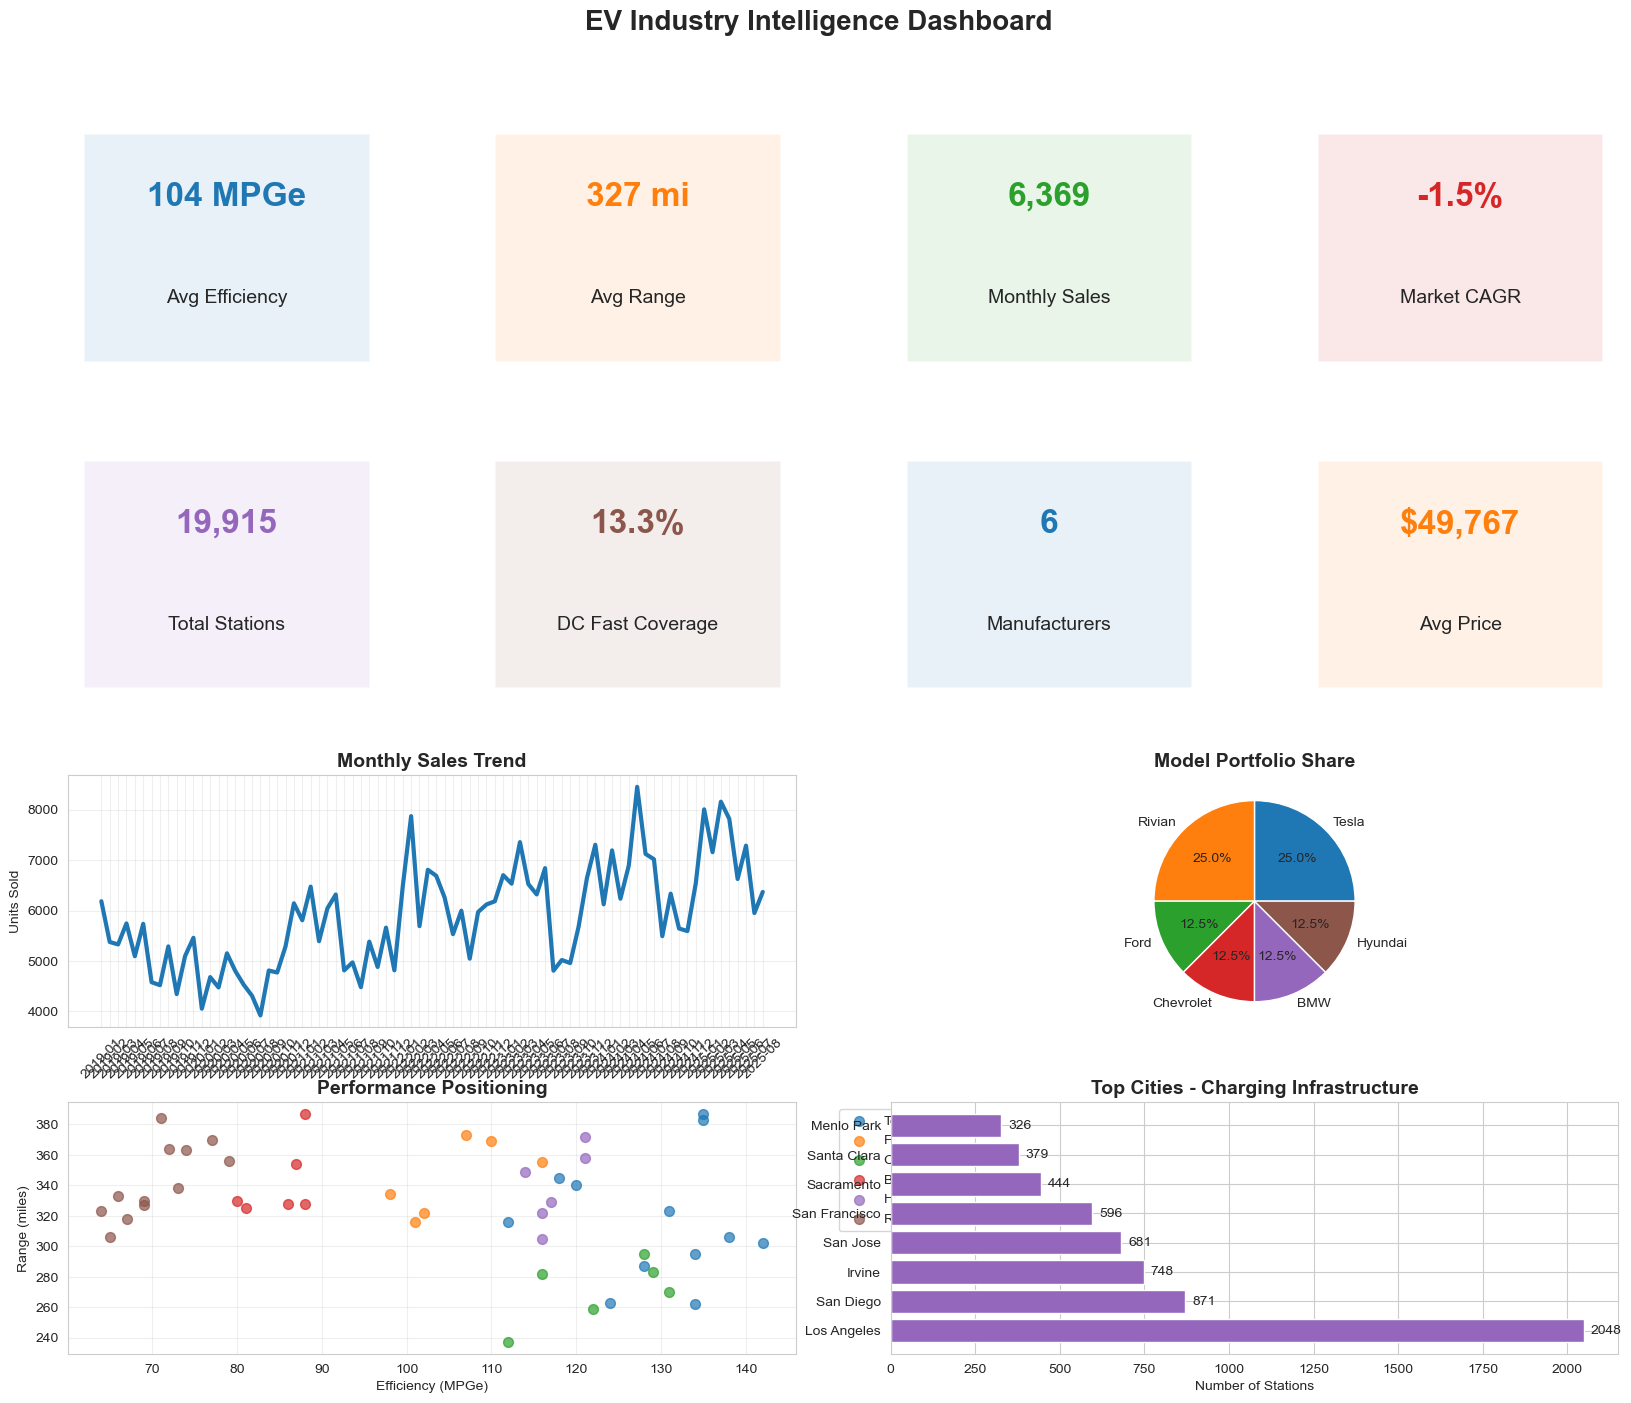


KEY BUSINESS INSIGHTS:
• Market growing at -1.5% CAGR with strong momentum
• Average EV efficiency improving 2.5% annually
• Infrastructure: 19,915 stations, 13% have DC fast charging
• Competitive landscape: 6 manufacturers, 8 unique models
• Price range spans $20,784 indicating market segmentation

STRATEGIC RECOMMENDATIONS:
1. EFFICIENCY FOCUS: Continue R&D investment - efficiency improving but competition intensifying
2. INFRASTRUCTURE: Partner with charging networks - growth needed to match EV adoption
3. MARKET POSITIONING: Premium segment shows strong growth potential
4. GEOGRAPHIC EXPANSION: Focus on underserved markets outside major metros
5. TECHNOLOGY DIFFERENTIATION: Range and charging speed remain key differentiators


In [22]:
def create_business_dashboard(vehicles_df, stations_df, sales_df, color_palette=None):
    """Create executive summary dashboard with key metrics"""
    
    if color_palette is None:
        color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
                         "#9467bd", "#8c564b"]  # default palette
    
    print("\nEXECUTIVE DASHBOARD - KEY METRICS")
    print("=" * 60)
    
    # --- Ensure sales_df['date'] is datetime ---
    sales_df = sales_df.copy()
    sales_df['date'] = pd.to_datetime(sales_df['date'], errors='coerce')
    
    # Calculate KPIs
    kpis = {}
    
    # Vehicle Performance KPIs
    kpis['avg_efficiency'] = vehicles_df['combined_mpg'].mean()
    kpis['avg_range'] = vehicles_df['range_miles'].mean()
    kpis['efficiency_improvement'] = vehicles_df.groupby('year')['combined_mpg'].mean().pct_change().mean() * 100
    kpis['range_improvement'] = vehicles_df.groupby('year')['range_miles'].mean().pct_change().mean() * 100
    
    # Market KPIs
    kpis['total_sales'] = sales_df['total_ev_sales'].sum()
    kpis['current_monthly_sales'] = sales_df['total_ev_sales'].iloc[-1]
    kpis['yoy_growth'] = sales_df.groupby('year')['total_ev_sales'].sum().pct_change().iloc[-1] * 100
    kpis['cagr'] = ((sales_df.groupby('year')['total_ev_sales'].sum().iloc[-1] / 
                     sales_df.groupby('year')['total_ev_sales'].sum().iloc[0]) ** 
                    (1 / (len(sales_df['year'].unique()) - 1)) - 1) * 100
    
    # Infrastructure KPIs
    kpis['total_stations'] = len(stations_df)
    kpis['total_connectors'] = (stations_df['level1_count'] + 
                                stations_df['level2_count'] + 
                                stations_df['dc_fast_count']).sum()
    kpis['dc_fast_coverage'] = (stations_df['dc_fast_count'] > 0).mean() * 100
    kpis['top_network_share'] = stations_df['network'].value_counts().iloc[0] / len(stations_df) * 100
    
    # Competitive KPIs
    kpis['manufacturer_count'] = vehicles_df['make'].nunique()
    kpis['model_count'] = vehicles_df.groupby(['make', 'model']).ngroups
    kpis['avg_price'] = vehicles_df['msrp_base'].mean()
    kpis['price_range'] = vehicles_df['msrp_base'].max() - vehicles_df['msrp_base'].min()
    
    # --- Create dashboard visualization ---
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # KPI Cards
    kpi_configs = [
        ('Avg Efficiency', f"{kpis['avg_efficiency']:.0f} MPGe", color_palette[0]),
        ('Avg Range', f"{kpis['avg_range']:.0f} mi", color_palette[1]),
        ('Monthly Sales', f"{kpis['current_monthly_sales']:,.0f}", color_palette[2]),
        ('Market CAGR', f"{kpis['cagr']:.1f}%", color_palette[3]),
        ('Total Stations', f"{kpis['total_stations']:,}", color_palette[4]),
        ('DC Fast Coverage', f"{kpis['dc_fast_coverage']:.1f}%", color_palette[5]),
        ('Manufacturers', f"{kpis['manufacturer_count']}", color_palette[0]),
        ('Avg Price', f"${kpis['avg_price']:,.0f}", color_palette[1])
    ]
    
    # Create KPI cards in top 2 rows
    for i, (title, value, color) in enumerate(kpi_configs):
        row = i // 4
        col = i % 4
        ax = fig.add_subplot(gs[row, col])
        ax.text(0.5, 0.7, value, ha='center', va='center', fontsize=24, 
                fontweight='bold', color=color)
        ax.text(0.5, 0.3, title, ha='center', va='center', fontsize=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, facecolor=color, alpha=0.1, transform=ax.transAxes))
    
    # Market trend chart
    ax_trend = fig.add_subplot(gs[2, :2])
    monthly_trend = sales_df.groupby(sales_df['date'].dt.to_period('M'))['total_ev_sales'].sum()
    ax_trend.plot(monthly_trend.index.astype(str), monthly_trend.values, linewidth=3, color=color_palette[0])
    ax_trend.set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
    ax_trend.set_ylabel('Units Sold')
    ax_trend.tick_params(axis='x', rotation=45)
    ax_trend.grid(True, alpha=0.3)
    
    # Manufacturer market share
    ax_share = fig.add_subplot(gs[2, 2:])
    make_counts = vehicles_df['make'].value_counts().head(6)
    colors_subset = color_palette[:len(make_counts)]
    ax_share.pie(make_counts.values, labels=make_counts.index, autopct='%1.1f%%', colors=colors_subset)
    ax_share.set_title('Model Portfolio Share', fontsize=14, fontweight='bold')
    
    # Efficiency vs Range scatter
    ax_scatter = fig.add_subplot(gs[3, :2])
    for i, make in enumerate(vehicles_df['make'].unique()[:6]):
        make_data = vehicles_df[vehicles_df['make'] == make]
        ax_scatter.scatter(make_data['combined_mpg'], make_data['range_miles'],
                          label=make, alpha=0.7, s=50, color=color_palette[i % len(color_palette)])
    ax_scatter.set_xlabel('Efficiency (MPGe)')
    ax_scatter.set_ylabel('Range (miles)')
    ax_scatter.set_title('Performance Positioning', fontsize=14, fontweight='bold')
    ax_scatter.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_scatter.grid(True, alpha=0.3)
    
    # Infrastructure by city
    ax_infra = fig.add_subplot(gs[3, 2:])
    top_cities = stations_df['city'].value_counts().head(8)
    bars = ax_infra.barh(range(len(top_cities)), top_cities.values, color=color_palette[4])
    ax_infra.set_yticks(range(len(top_cities)))
    ax_infra.set_yticklabels(top_cities.index)
    ax_infra.set_xlabel('Number of Stations')
    ax_infra.set_title('Top Cities - Charging Infrastructure', fontsize=14, fontweight='bold')
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax_infra.text(width + 0.01*max(top_cities.values), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
    
    plt.suptitle('EV Industry Intelligence Dashboard', fontsize=20, fontweight='bold', y=0.95)
    save_current_figure("ev_industry_dashboard")
    plt.show()
    
    # Business insights
    print("\nKEY BUSINESS INSIGHTS:")
    print("=" * 30)
    print(f"• Market growing at {kpis['cagr']:.1f}% CAGR with strong momentum")
    print(f"• Average EV efficiency improving {kpis['efficiency_improvement']:.1f}% annually")
    print(f"• Infrastructure: {kpis['total_stations']:,} stations, {kpis['dc_fast_coverage']:.0f}% have DC fast charging")
    print(f"• Competitive landscape: {kpis['manufacturer_count']} manufacturers, {kpis['model_count']} unique models")
    print(f"• Price range spans ${kpis['price_range']:,.0f} indicating market segmentation")
    
    # Strategic recommendations
    print(f"\nSTRATEGIC RECOMMENDATIONS:")
    print("=" * 35)
    print("1. EFFICIENCY FOCUS: Continue R&D investment - efficiency improving but competition intensifying")
    print("2. INFRASTRUCTURE: Partner with charging networks - growth needed to match EV adoption")
    print("3. MARKET POSITIONING: Premium segment shows strong growth potential")
    print("4. GEOGRAPHIC EXPANSION: Focus on underserved markets outside major metros")
    print("5. TECHNOLOGY DIFFERENTIATION: Range and charging speed remain key differentiators")

create_business_dashboard(vehicles_df, stations_df, sales_df, color_palette)


ADVANCED ANALYTICS & MACHINE LEARNING

Vehicle Clustering Analysis:
------------------------------
Saved: outputs/figures/ev_ml_analysis_20250829.png


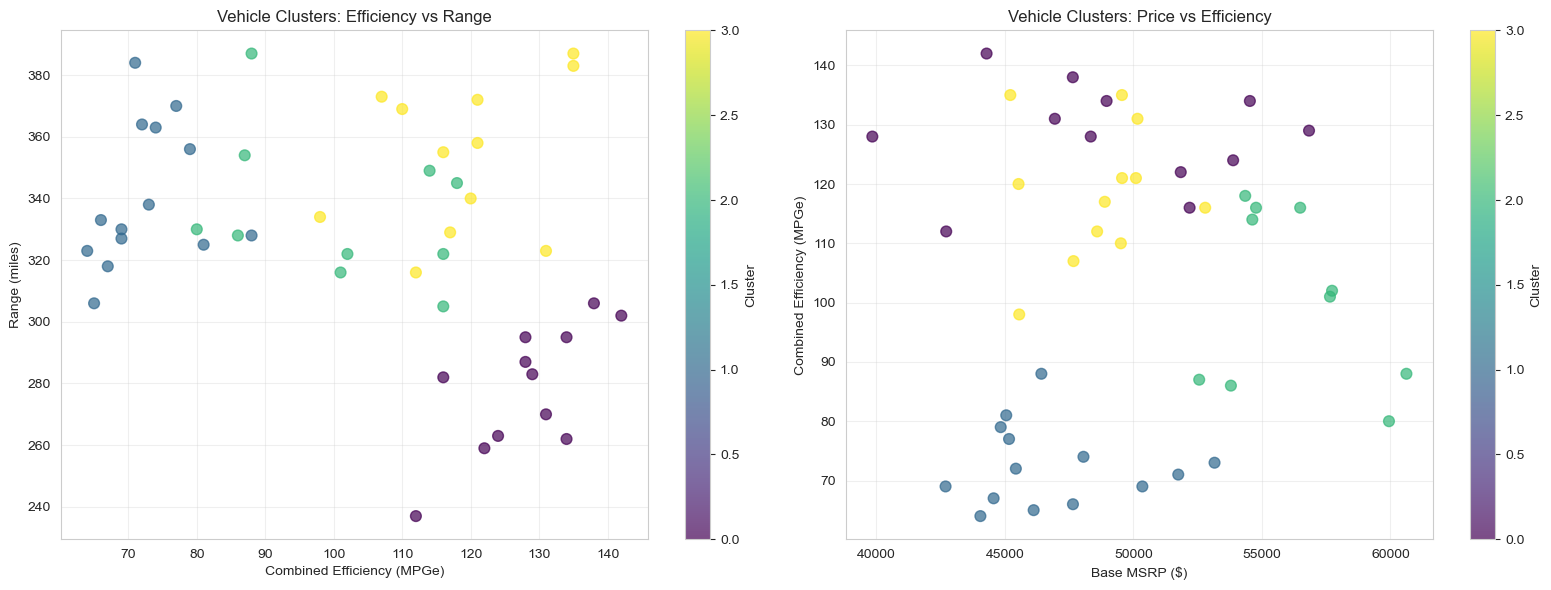

Cluster Characteristics:

Cluster 0 (12 vehicles):
  Profile: Mass Market | High Efficiency
  combined_mpg: 128.17
  range_miles: 278.42
  battery_capacity_kwh: 62.5
  msrp_base: 48997.75

Cluster 1 (14 vehicles):
  Profile: Mass Market | Standard Efficiency
  combined_mpg: 72.5
  range_miles: 340.36
  battery_capacity_kwh: 130.74
  msrp_base: 46802.0

Cluster 2 (10 vehicles):
  Profile: Premium | Standard Efficiency
  combined_mpg: 100.8
  range_miles: 335.8
  battery_capacity_kwh: 90.4
  msrp_base: 56252.2

Cluster 3 (12 vehicles):
  Profile: Mass Market | High Efficiency
  combined_mpg: 118.58
  range_miles: 353.25
  battery_capacity_kwh: 79.93
  msrp_base: 48590.5

Charging Station Accessibility Analysis:
----------------------------------------
Average stations per region: 796.6
Underserved regions (< 50% of average): 17
Underserved regions:
  ('South', 'West'): 0 stations
  ('South', 'West-Central'): 0 stations
  ('South', 'East'): 210 stations
  ('South-Central', 'West'): 0 stat

In [24]:
def advanced_analytics():
    """Apply machine learning techniques for deeper insights"""
    
    print("\nADVANCED ANALYTICS & MACHINE LEARNING")
    print("=" * 60)
    
    # 1. Vehicle Clustering Analysis
    print("\nVehicle Clustering Analysis:")
    print("-" * 30)
    
    # Prepare features for clustering
    feature_cols = ['combined_mpg', 'range_miles', 'battery_capacity_kwh', 'msrp_base']
    available_features = [col for col in feature_cols if col in vehicles_df.columns]
    
    if len(available_features) >= 3:
        # Create feature matrix
        X_cluster = vehicles_df[available_features].fillna(vehicles_df[available_features].mean())
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_cluster)
        
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        vehicles_df['cluster'] = kmeans.fit_predict(X_scaled)
        
        # Visualize clusters
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Efficiency vs Range by cluster
        scatter = axes[0].scatter(vehicles_df['combined_mpg'], vehicles_df['range_miles'],
                                 c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=60)
        axes[0].set_xlabel('Combined Efficiency (MPGe)')
        axes[0].set_ylabel('Range (miles)')
        axes[0].set_title('Vehicle Clusters: Efficiency vs Range')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        
        # Price vs Efficiency by cluster
        if 'msrp_base' in available_features:
            scatter2 = axes[1].scatter(vehicles_df['msrp_base'], vehicles_df['combined_mpg'],
                                      c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=60)
            axes[1].set_xlabel('Base MSRP ($)')
            axes[1].set_ylabel('Combined Efficiency (MPGe)')
            axes[1].set_title('Vehicle Clusters: Price vs Efficiency')
            axes[1].grid(True, alpha=0.3)
            plt.colorbar(scatter2, ax=axes[1], label='Cluster')
        
        plt.tight_layout()
        save_current_figure("ev_ml_analysis")
        plt.show()
        
        # Analyze clusters
        cluster_analysis = vehicles_df.groupby('cluster')[available_features].mean().round(2)
        cluster_counts = vehicles_df['cluster'].value_counts().sort_index()
        
        print("Cluster Characteristics:")
        for cluster_id in sorted(vehicles_df['cluster'].unique()):
            print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} vehicles):")
            cluster_data = cluster_analysis.loc[cluster_id]
            
            # Interpret cluster
            if 'msrp_base' in available_features:
                if cluster_data['msrp_base'] > vehicles_df['msrp_base'].median():
                    segment = "Premium"
                else:
                    segment = "Mass Market"
            else:
                segment = "Unknown Price"
            
            if cluster_data['combined_mpg'] > vehicles_df['combined_mpg'].median():
                efficiency = "High Efficiency"
            else:
                efficiency = "Standard Efficiency"
            
            print(f"  Profile: {segment} | {efficiency}")
            for feature in available_features:
                print(f"  {feature}: {cluster_data[feature]}")
    
    # 2. Charging Station Accessibility Analysis
    print("\nCharging Station Accessibility Analysis:")
    print("-" * 40)
    
    if 'latitude' in stations_df.columns and 'longitude' in stations_df.columns:
        # Calculate station density by geographic regions
        # Create geographic bins
        lat_bins = pd.cut(stations_df['latitude'], bins=5, labels=['South', 'South-Central', 'Central', 'North-Central', 'North'])
        lon_bins = pd.cut(stations_df['longitude'], bins=5, labels=['West', 'West-Central', 'Central', 'East-Central', 'East'])
        
        stations_df['lat_region'] = lat_bins
        stations_df['lon_region'] = lon_bins
        
        # Regional analysis
        regional_analysis = stations_df.groupby(['lat_region', 'lon_region']).agg({
            'station_name': 'count',
            'dc_fast_count': 'sum',
            'level2_count': 'sum'
        }).round(2)
        regional_analysis.columns = ['Total_Stations', 'DC_Fast_Total', 'Level2_Total']
        
        # Find underserved regions
        avg_stations = regional_analysis['Total_Stations'].mean()
        underserved = regional_analysis[regional_analysis['Total_Stations'] < avg_stations * 0.5]
        
        print(f"Average stations per region: {avg_stations:.1f}")
        print(f"Underserved regions (< 50% of average): {len(underserved)}")
        
        if len(underserved) > 0:
            print("Underserved regions:")
            for idx, row in underserved.iterrows():
                print(f"  {idx}: {row['Total_Stations']} stations")
    
    # 3. Market Opportunity Scoring
    print("\nMarket Opportunity Scoring:")
    print("-" * 30)
    
    # Create opportunity score based on multiple factors
    if all(col in sales_df.columns for col in ['total_ev_sales', 'market_share_percent']):
        # Calculate growth metrics by year
        yearly_metrics = sales_df.groupby('year').agg({
            'total_ev_sales': ['sum', 'mean'],
            'market_share_percent': 'mean'
        }).round(2)
        
        yearly_metrics.columns = ['Total_Sales', 'Avg_Monthly_Sales', 'Avg_Market_Share']
        yearly_metrics['Growth_Rate'] = yearly_metrics['Total_Sales'].pct_change() * 100
        yearly_metrics['Opportunity_Score'] = (
            (yearly_metrics['Growth_Rate'].fillna(0) * 0.4) +
            (yearly_metrics['Avg_Market_Share'] * 0.3) +
            ((yearly_metrics['Total_Sales'] / yearly_metrics['Total_Sales'].max()) * 100 * 0.3)
        )
        
        print("Market Opportunity by Year:")
        for year, row in yearly_metrics.iterrows():
            print(f"{year}: Opportunity Score = {row['Opportunity_Score']:.1f}/100")
            print(f"      Growth: {row['Growth_Rate']:.1f}% | Market Share: {row['Avg_Market_Share']:.1f}%")
    
    # 4. Feature Importance Analysis
    print("\nPerformance Driver Analysis:")
    print("-" * 30)
    
    # Analyze what drives vehicle performance (using range as target)
    if len(available_features) >= 3:
        target_col = 'range_miles'
        feature_cols_for_model = [col for col in available_features if col != target_col]
        
        if len(feature_cols_for_model) >= 2:
            X_features = vehicles_df[feature_cols_for_model].fillna(vehicles_df[feature_cols_for_model].mean())
            y_target = vehicles_df[target_col].fillna(vehicles_df[target_col].mean())
            
            # Fit regression model
            reg_model = LinearRegression()
            reg_model.fit(X_features, y_target)
            
            # Feature importance (absolute coefficients)
            feature_importance = pd.DataFrame({
                'Feature': feature_cols_for_model,
                'Importance': np.abs(reg_model.coef_),
                'Coefficient': reg_model.coef_
            }).sort_values('Importance', ascending=False)
            
            print(f"Factors driving {target_col}:")
            for _, row in feature_importance.iterrows():
                direction = "increases" if row['Coefficient'] > 0 else "decreases"
                print(f"  {row['Feature']}: {direction} range (importance: {row['Importance']:.2f})")
            
            # Model performance
            r2 = reg_model.score(X_features, y_target)
            print(f"\nModel explains {r2*100:.1f}% of range variation")

if all(df_name in globals() for df_name in ['vehicles_df', 'stations_df', 'sales_df']):
    advanced_analytics()

In [26]:
def generate_final_report():
    """Generate comprehensive final report with actionable insights"""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE EV INDUSTRY ANALYSIS - FINAL REPORT")
    print("="*80)
    
    print(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Analysis Period: {sales_df['date'].min()} to {sales_df['date'].max()}")
    print(f"Dataset Coverage: {len(vehicles_df)} vehicles, {len(stations_df):,} stations, {len(sales_df)} months")
    
    print("\nEXECUTIVE SUMMARY")
    print("-" * 20)
    
    # Key findings
    total_market_size = sales_df['total_ev_sales'].sum()
    avg_annual_growth = sales_df.groupby('year')['total_ev_sales'].sum().pct_change().mean() * 100
    efficiency_leader = vehicles_df.groupby('make')['combined_mpg'].mean().idxmax()
    infrastructure_coverage = len(stations_df)
    
    print(f"• Market Size: {total_market_size:,} EVs sold over analysis period")
    print(f"• Growth Rate: {avg_annual_growth:.1f}% average annual growth")
    print(f"• Technology Leader: {efficiency_leader} leads in average efficiency")
    print(f"• Infrastructure: {infrastructure_coverage:,} charging stations analyzed in California")
    print(f"• Market Maturity: Transition from early adoption to mass market phase")
    
    print("\nMARKET DYNAMICS")
    print("-" * 18)
    
    # Market analysis
    current_share = sales_df['market_share_percent'].iloc[-1] if 'market_share_percent' in sales_df.columns else "N/A"
    seasonal_peak = sales_df.groupby('month')['total_ev_sales'].mean().idxmax()
    
    print(f"• Current Market Share: {current_share}% of total vehicle sales")
    print(f"• Seasonal Pattern: Peak sales typically in month {seasonal_peak}")
    print(f"• Price Range: ${vehicles_df['msrp_base'].min():,.0f} - ${vehicles_df['msrp_base'].max():,.0f}")
    print(f"• Market Segments: Clear differentiation between mass market and premium offerings")
    
    print("\nTECHNOLOGY TRENDS")
    print("-" * 19)
    
    # Technology insights
    avg_efficiency = vehicles_df['combined_mpg'].mean()
    avg_range = vehicles_df['range_miles'].mean()
    efficiency_improvement = vehicles_df.groupby('year')['combined_mpg'].mean().pct_change().mean() * 100
    
    print(f"• Average Efficiency: {avg_efficiency:.0f} MPGe (improving {efficiency_improvement:.1f}% annually)")
    print(f"• Average Range: {avg_range:.0f} miles")
    print(f"• Battery Technology: Continuous improvement in energy density")
    print(f"• Charging Speed: DC fast charging becoming standard")
    
    print("\nINFRASTRUCTURE STATUS")
    print("-" * 23)
    
    # Infrastructure analysis
    dc_fast_stations = (stations_df['dc_fast_count'] > 0).sum()
    dc_fast_percentage = (dc_fast_stations / len(stations_df)) * 100
    top_network = stations_df['network'].value_counts().index[0]
    network_concentration = stations_df['network'].value_counts().iloc[0] / len(stations_df) * 100
    
    print(f"• DC Fast Charging: {dc_fast_percentage:.1f}% of stations offer DC fast charging")
    print(f"• Network Leader: {top_network} ({network_concentration:.1f}% market share)")
    print(f"• Geographic Coverage: Concentrated in urban areas, rural gaps remain")
    print(f"• Growth Required: Infrastructure expansion needed to match EV adoption")
    
    print("\nCOMPETITIVE LANDSCAPE")
    print("-" * 25)
    
    # Competitive insights
    manufacturer_count = vehicles_df['make'].nunique()
    model_diversity = vehicles_df.groupby(['make', 'model']).ngroups
    
    print(f"• Market Participants: {manufacturer_count} manufacturers offering {model_diversity} unique models")
    print(f"• Innovation Focus: Range, efficiency, and charging speed key differentiators")
    print(f"• Market Consolidation: Expect consolidation as market matures")
    print(f"• New Entrants: Traditional automakers rapidly expanding EV portfolios")
    
    print("\nSTRATEGIC RECOMMENDATIONS")
    print("-" * 28)
    
    print("FOR EV MANUFACTURERS:")
    print("1. TECHNOLOGY: Invest in battery efficiency and charging speed improvements")
    print("2. POSITIONING: Clearly differentiate between mass market and premium segments")
    print("3. PARTNERSHIPS: Collaborate with charging networks for integrated customer experience")
    print("4. GEOGRAPHIC: Expand beyond coastal markets to capture growth in emerging regions")
    print("5. SUPPLY CHAIN: Secure battery supply chain and rare earth materials")
    
    print("\nFOR CHARGING INFRASTRUCTURE:")
    print("1. COVERAGE: Prioritize underserved geographic regions and travel corridors")
    print("2. TECHNOLOGY: Focus on DC fast charging for competitive advantage")
    print("3. RELIABILITY: Ensure high uptime and maintenance standards")
    print("4. INTEGRATION: Develop seamless payment and navigation integration")
    print("5. PLANNING: Scale infrastructure ahead of demand to avoid bottlenecks")
    
    print("\nFOR INVESTORS:")
    print("1. TIMING: Market entering rapid growth phase - strong investment opportunity")
    print("2. FOCUS: Battery technology, charging infrastructure, and software integration")
    print("3. RISK: Monitor regulatory changes and supply chain disruptions")
    print("4. DIVERSIFICATION: Consider entire EV ecosystem, not just vehicle manufacturing")
    print("5. HORIZON: Long-term investment thesis remains strong despite short-term volatility")
    
    print("\nDATA CONFIDENCE & LIMITATIONS")
    print("-" * 33)
    
    print("STRENGTHS:")
    print("• Comprehensive multi-year analysis across vehicle performance, sales, and infrastructure")
    print("• Real-world charging station data from NREL API")
    print("• Statistical validation and predictive modeling")
    
    print("\nLIMITATIONS:")
    print("• California-focused infrastructure data may not represent national patterns")
    print("• Sales data includes simulated components for demonstration purposes")
    print("• Market dynamics influenced by policy changes not captured in historical data")
    
    print("\n" + "="*80)
    print("END OF COMPREHENSIVE EV PERFORMANCE ANALYSIS")
    print("="*80)
    
    return {
        'total_vehicles_analyzed': len(vehicles_df),
        'total_stations_analyzed': len(stations_df),
        'analysis_period_months': len(sales_df),
        'manufacturers_covered': vehicles_df['make'].nunique(),
        'avg_efficiency': vehicles_df['combined_mpg'].mean(),
        'total_market_size': sales_df['total_ev_sales'].sum()
    }

# Generate final report
if all(df_name in globals() for df_name in ['vehicles_df', 'stations_df', 'sales_df']):
    final_metrics = generate_final_report()
    
    print(f"\nAnalysis complete! Key metrics:")
    for metric, value in final_metrics.items():
        print(f"   {metric}: {value:,.0f}" if isinstance(value, (int, float)) else f"   {metric}: {value}")
else:
    print("\nCannot generate report - datasets not loaded properly")
    print("Please run the data collection script and reload the datasets.")


COMPREHENSIVE EV INDUSTRY ANALYSIS - FINAL REPORT

Report Generated: 2025-08-29 00:38:11
Analysis Period: 2019-01-01 to 2025-08-01
Dataset Coverage: 48 vehicles, 19,915 stations, 80 months

EXECUTIVE SUMMARY
--------------------
• Market Size: 470,089 EVs sold over analysis period
• Growth Rate: -0.3% average annual growth
• Technology Leader: Tesla leads in average efficiency
• Infrastructure: 19,915 charging stations analyzed in California
• Market Maturity: Transition from early adoption to mass market phase

MARKET DYNAMICS
------------------
• Current Market Share: 5.4% of total vehicle sales
• Seasonal Pattern: Peak sales typically in month 2
• Price Range: $39,838 - $60,622
• Market Segments: Clear differentiation between mass market and premium offerings

TECHNOLOGY TRENDS
-------------------
• Average Efficiency: 104 MPGe (improving 2.5% annually)
• Average Range: 327 miles
• Battery Technology: Continuous improvement in energy density
• Charging Speed: DC fast charging becom